In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt
import warnings

from torchmetrics.classification import BinaryAccuracy
import os
import shutil
from util import EarlyStopping


warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
discharge_capacities = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities = discharge_capacities.tolist()

In [3]:
def get_data(discharge_capacities,percentage,window_size,stride,channels,type):

    train_data =[]
    FPC_data  =[]
    name = 0
    test_data = []
    
    if(type == "train"):
        
        for battery in discharge_capacities:
            a = len(FPC_data)
            battery = np.asarray(battery)
            
            battery_name = 'battery' + str(name)
            name = name+1
            
            # Taking inital x% as input and giving the output as 1
            i= 0
            target = 1
            while(i+stride+window_size <= int(percentage*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target,battery_name ))
                i = i+stride

            # Taking inputs in the middle for FPC
            i = int(percentage*len(battery[0]))
            target = -1
            while(i+stride+window_size <= int((1-percentage)*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                FPC_data.append((battery[:channels,i:i+window_size], target,battery_name))
                i = i+stride

            # Taking last x% as input and giving the output as 0
            i = int((1-percentage)*len(battery[0]))
            target = 0
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target ,battery_name))
                i = i+stride
            # print(len(FPC_data)-a, len(battery[0]), len(FPC_data)-a- .90*len(battery[0]))

        return train_data,FPC_data

    else:
        name = 100
        for battery in discharge_capacities:
            battery = np.asarray(battery)
            i= 0
            battery_name = 'battery' + str(name)
            name = name+1
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                test_data.append((battery[:channels,i:i+window_size], 1,battery_name))
                i = i+stride

        return test_data


In [4]:
class battery_dataloader(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        name = self.data[idx][2]
        return inp, output,name 

In [5]:
percentage  = 0.10  # 10 percent data
window_size = 50    # window size
stride = 1          # stride
channels  = 7       # channels


train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

obj_train  = battery_dataloader(train_data)
obj_FPC  = battery_dataloader(FPC_data)
obj_test  = battery_dataloader(test_data)


train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)


In [6]:
print("Number of Channels  :", channels)
print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)

Number of Channels  : 7
Shape of a batch    : torch.Size([8, 7, 50])


In [7]:
import math
class CNN_Model(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model, self).__init__()
        self.name = "CNN"
        filter_size_1 = 21
        filter_size=21
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        out = self.conv3(out)
        out = self.relu(out)
        out = self.batch_norm3(out)
        out = self.dropout(out)
        out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)

        out = self.sigmoid(out)
        return out

In [8]:

def train_model(window_size,channels,train_dataloader,epochs, load_pretrained,path,dir):
    
    
    try:
        shutil.rmtree("./Weights")
        os.mkdir(".Weights")
    except:
        os.mkdir("/Weights")
    
    model = CNN_Model(window_size,channels)
    if(load_pretrained):
        model.load_state_dict(torch.load(path, map_location=device ))

    
    model.to(device)

    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
    criterion = nn.BCELoss()
    metric = BinaryAccuracy().to(device)
    early_stopping = EarlyStopping(patience=50)


    for epoch in range(epochs):
        total_loss = 0
        model.train()
        model.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batches = 0
        for x, y ,_ in train_dataloader:

            x = x.to(device=device)
            y = y.to(device=device)
            out = model(x)
            acc += metric(out, y.unsqueeze(1))

            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batches +=1


        print("Loss = {} Accuarcy ={}".format(total_loss/total,acc/total_batches))

        evaluation = total_loss/total
        early_stopping(evaluation, \
                        model, f'{dir}/model_f{channels}_f{window_size}.pth')
        if early_stopping.early_stop:
            print('Early stopping')
            break

    return model

In [9]:
epochs = 100
window_size = 50
channels = 7

pretrained = True
load_pretrained = True

if(pretrained):
    model = CNN_Model(window_size,channels)
    model.load_state_dict(torch.load("./Weights/FPC/model_f7_f50.pth", map_location=device ))
    model.to(device)
else:
    model = train_model(window_size,channels,train_dataloader,epochs,load_pretrained,"./Weights/FPC/model_f7_f50.pth" ,"./Weights/FPC/")



In [10]:
def get_fpc_window(pred,patiance):
    
    count = 0
    for window,pred_value in enumerate(pred):
        if(pred_value.item() ==0):
            count =  count +1
        if(pred_value.item() ==1):
            count =0
        if(window == len(pred)-1):
            change_index = window-count
            return change_index,[1.0 if i<change_index else 0.0 for i in range(len(pred))]
        if(count == patiance):
            change_index = window - patiance
            return change_index,[1.0 if i<change_index else 0.0 for i in range(len(pred))]

In [11]:
def get_fpc(model,batteries,discharge_capacities,data_loader,plot,show_FPC_curve,add_initial,save_path):
    
    plt.figure()
    if(plot):
        rows = 2
        col  = 7
        fig, ax = plt.subplots(col,rows,figsize=(16,16))
        ax = ax.flatten()
        plt.suptitle("Results", fontsize = 20)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    
    change_percentage = []
    change_indices    = []
    model.eval()
    pred = []
    
    
    for ind,battery in enumerate(batteries):
        pred = []
        count = 0
        for x, y ,_ in data_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            initial_count = count                # This is used to avoid iterating over all batteries in the dataset 
            if(_[0][7:] == str(battery)):
                out = torch.where(model(x) > 0.5, 1, 0)
                pred.append(out.cpu().detach().numpy()[0][0].astype(float))
                count = count +1
            if(initial_count==count and count >1):
                break

        index,smoothed_output = get_fpc_window(pred,patiance=10)   # Index where the the transition occurs
        index = index*stride

        if(add_initial):
            change_indices.append(index+int(percentage*len(discharge_capacities[battery][0])))
        else:
            change_indices.append(index)
        
        change_percentage.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))
        
        if(show_FPC_curve):
            FPC_curve = np.copy(discharge_capacities[battery][0])
            FPC_curve[1:int(percentage*len(discharge_capacities[battery][0]))] = None
            FPC_curve[int((1-percentage)*len(discharge_capacities[battery][0])):-1] = None

            Non_FPC_curve = np.copy(discharge_capacities[battery][0])
            Non_FPC_curve[int(percentage*len(discharge_capacities[battery][0])):int((1-percentage)*len(discharge_capacities[battery][0]))] = None
    
            pred_padded = np.pad(pred, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))
            smoothed_output_padded = np.pad(smoothed_output, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))
            
            if(plot == True):
                ax[ind].plot(FPC_curve, color = 'orange')
                ax[ind].plot(Non_FPC_curve, color ='red')
                ax[ind].plot(pred_padded,color ='blue')
                ax[ind].plot(smoothed_output_padded,color ='black')
        
                ax[ind].legend(["FPC", "NON-FPC","Prediction","Smoothed Output"])
                ax[ind].set_title("Battery =" +str(battery))
        else:
            if(plot):
                
                ax[ind].plot(discharge_capacities[battery][0], color = 'orange')
                ax[ind].plot(pred, color ='red')
                ax[ind].plot(smoothed_output, color ='black')
                ax[ind].legend(["Actual", "Prediction", "Smoothed Prediction"])
                ax[ind].set_title("Battery =" +str(battery))
                
    plt.savefig(save_path+"png")
    return change_percentage, change_indices





<Figure size 432x288 with 0 Axes>

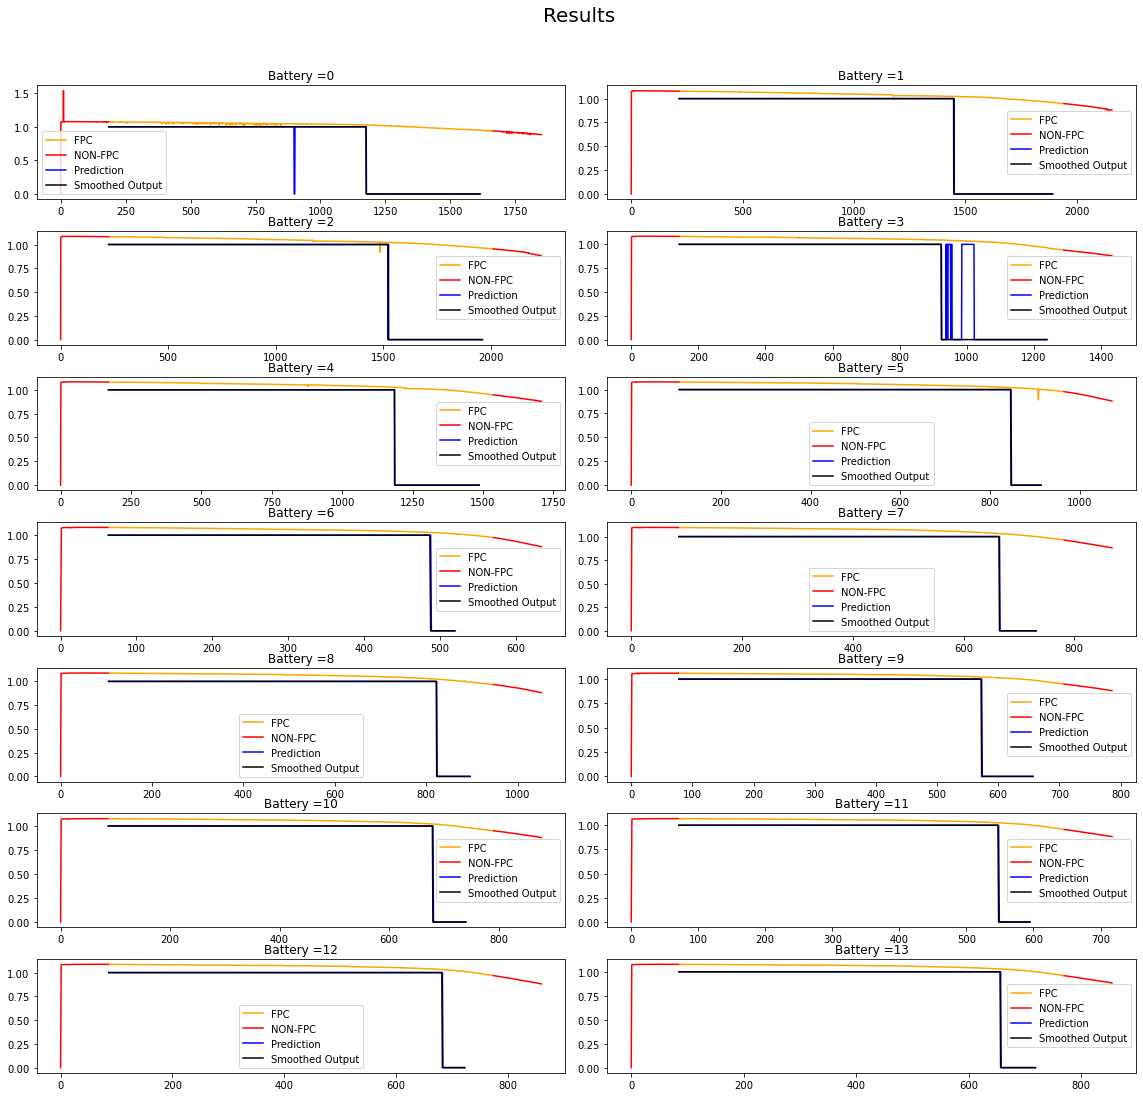

In [12]:
batteries = [i for i in range(0,14)]
_,_ = get_fpc(model,batteries,discharge_capacities,FPC_dataloader,True, True,True,"FPC_Training")

<Figure size 432x288 with 0 Axes>

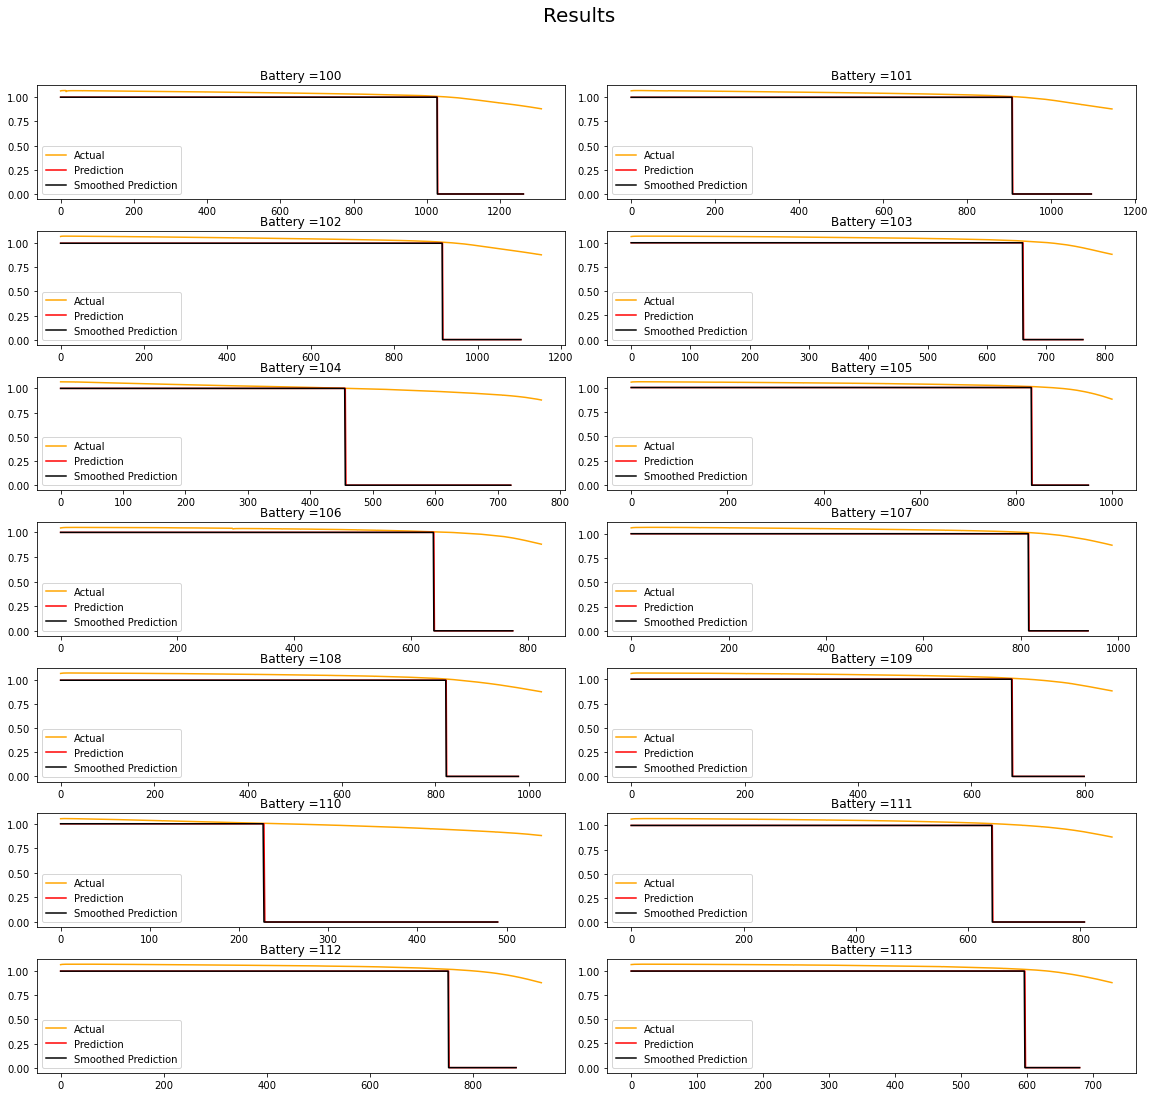

In [13]:
batteries = [i+100 for i in range(0,14)]
_,_ = get_fpc(model,batteries,discharge_capacities,test_dataloader,True, False,False,"FPC_Testing")

In [14]:
no_of_channels = [1,2,3,4,5,6,7]
no_of_channels = [7]
changes_train = []
changes_test = []
epochs = 50
# os.mkdir("/kaggle/working/change_indices")
get_saved_indices = True

if(not get_saved_indices):

    for channels in no_of_channels: 
        print("Channels used : ", channels)
        percentage  = 0.10  # 5 percent data
        window_size = 50    # window size
        stride = 1          # stride

        train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
        test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

        obj_train  = battery_dataloader(train_data)
        obj_FPC  = battery_dataloader(FPC_data)
        obj_test  = battery_dataloader(test_data)

        train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
        FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
        test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)

        print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
   

        batteries_train =[i for i in range (100)]
        batteries_test= [i+100 for i in range(0,24)]

        change_percentage_train, change_indices_train =  get_fpc(model,batteries_train,discharge_capacities,FPC_dataloader,False, False,True)
        change_percentage_test, change_indices_test =  get_fpc(model,batteries_test,discharge_capacities,test_dataloader,False, False,False)


        changes_train.append(np.mean(change_percentage_train))
        changes_test.append(np.mean(change_percentage_test))
        
        
        if(os.path.exists("./change_indices") == False):
            os.mkdir("./change_indices")

        np.save("./change_indices/change_indices_train.npy",change_indices_train, allow_pickle=True)
        np.save("./change_indices/change_indices_test.npy",change_indices_test, allow_pickle=True)

        np.save("./change_indices/change_percentage_train.npy",change_percentage_train, allow_pickle=True)
        np.save("./change_indices/change_percentage_test.npy",change_percentage_test, allow_pickle=True)

else:
    print("Loading Pre")
    change_indices_train = np.load("./change_indices/change_indices_train.npy" , allow_pickle=True)
    change_indices_test = np.load("./change_indices/change_indices_test.npy",allow_pickle=True)

    # change_percentage_train = np.load("./change_indices/change_percentage_train.npy",allow_pickle=True)
    # change_percentage_test = np.load("/change_indices/change_percentage_test.npy",allow_pickle=True)

    


# import pandas as pd
# results = pd.DataFrame([changes_train,changes_test], columns=no_of_channels, index=["Train","Test"])
# results.to_csv('channel_analysis.csv')

Loading Pre
Mean FPC Percentage Train :  538.53
Mean FPC Percentage Test :  802.625


In [15]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)), (max(data), min(data))


def get_data_RUL(discharge_capacities,change_indices, window_size,stride,channels, type):
        
        if(type == "Train"):
            
            train_data =[]
            for index,battery in enumerate(discharge_capacities):
                    battery = np.array(battery)
                    battery_name = "battery" + str(index)
                    i = change_indices[index]
                    
                    percentage_index = 0
                    normalized_capacity,_ = NormalizeData(battery[0][i:])

                    while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                            train_data.append((battery[:channels,i:i+window_size], normalized_capacity[percentage_index],battery_name ))
                            i = i+stride
                            percentage_index = percentage_index+1

            return train_data
        else:
            print(type)
            test_data =[]
            for index,battery in enumerate(discharge_capacities):
                    battery = np.array(battery)
                    battery_name = "battery" + str(index+100)
                    i = change_indices[index]
                    percentage_index = 0
                    normalized_capacity,_ = NormalizeData(battery[0][i:])

                    while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                            test_data.append((battery[:channels,i:i+window_size], normalized_capacity[percentage_index],battery_name ))
                            i = i+stride
                            percentage_index = percentage_index+1
            return test_data
        
def get_data_RUL_scenario1(discharge_capacities,change_indices, window_size,stride,channels, type):
        
        if(type == "Train"):
            
            train_data =[]
            for index,battery in enumerate(discharge_capacities):
                    battery = np.array(battery)
                    battery_name = "battery" + str(index)
                    i = change_indices[index]   # FPC cycle
                    
                    percentage_index = 0
                    
                    EOL = len(battery[0])

                    while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                            train_data.append((battery[:channels,i:i+window_size], 1-((i-change_indices[index])/(EOL - change_indices[index])),battery_name ))
                            i = i+stride
                            percentage_index = percentage_index+1

            return train_data
        else:
            print(type)
            test_data =[]
            for index,battery in enumerate(discharge_capacities):
                    battery = np.array(battery)
                    battery_name = "battery" + str(index+100)
                    i = change_indices[index]   # FPC cycle
                    percentage_index = 0
                    
                    EOL = len(battery[0])
                    

                    while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                            test_data.append((battery[:channels,i:i+window_size], 1-(i-change_indices[index])/(EOL - change_indices[index]),battery_name ))
                            i = i+stride
                            percentage_index = percentage_index+1
                        
            return test_data
       
            

In [16]:
import math
class CNN_Model_RUL(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model_RUL, self).__init__()
        self.name = "CNN"
        filter_size_1 = 5
        filter_size   = 5
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        # out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        # out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        # out = self.conv3(out)
        # out = self.relu(out)
        # out = self.batch_norm3(out)
        # out = self.dropout(out)
        # out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)
#         out = self.sigmoid(out)

        return out

In [17]:
class LSTM_Model_RUL(nn.Module):
    
    def __init__(self,input_size,channels):
        super(LSTM_Model_RUL, self).__init__()
        self.name = "LSTM"
        hidden_size1 = input_size
        hidden_size2 = input_size
        
        num_layers = 4
        self.LSTM1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size1, num_layers = num_layers,batch_first=True)
        self.LSTM2 = nn.LSTM(input_size = input_size, hidden_size = hidden_size2, num_layers = num_layers,batch_first=True)

        self.flatten = nn.Flatten()
        self.Linear1 = nn.Linear(hidden_size2*channels,128)
        self.Linear2 = nn.Linear(128,1)
        self.Linear3 = nn.Linear(50,1)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        
        # self.h0 = torch.randn(4, x.size(0), 100)
        # self.c0 = torch.randn(4, x.size(0), 100)
        
        # x= x.view(x.shape[0],channels,x.shape[1])
        # out, (hn, cn) = self.LSTM(x, (self.h0, self.c0))

        out, (_, _) = self.LSTM1(x)
        out,(_,_) = self.LSTM2(out)
        
        out = self.flatten(out)
        out = self.relu(out)
        out = self.Linear1(out)
        out = self.relu(out)
        out = self.Linear2(out)
#         out = self.relu(out)
#         out = self.Linear3(out)
#         out = self.sigmoid(out)


        return out

In [18]:
class battery_dataloader_RUL(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        battery_name = self.data[idx][2]
        
        return inp, output, battery_name

In [19]:
channels = 7
window_size = 50
stride =1

train_data_RUL= get_data_RUL(discharge_capacities[:100],change_indices_train,window_size,stride,channels,"Train")
obj_train_RUL  = battery_dataloader_RUL(train_data_RUL)

test_data_RUL= get_data_RUL(discharge_capacities[100:],change_indices_test,window_size,stride,channels,"Test")
obj_test_RUL  = battery_dataloader_RUL(test_data_RUL)


train_data_RUL_scenario1= get_data_RUL_scenario1(discharge_capacities[:100],change_indices_train,window_size,stride,channels,"Train")
obj_train_RUL_scenario1  = battery_dataloader_RUL(train_data_RUL_scenario1)

test_data_RUL_scenario1= get_data_RUL_scenario1(discharge_capacities[100:],change_indices_test,window_size,stride,channels,"Test")
obj_test_RUL_scenario1  = battery_dataloader_RUL(test_data_RUL_scenario1)



train_dataloader_RUL = DataLoader(obj_train_RUL, batch_size=128,shuffle=True)
train_dataloader_RUL_temp = DataLoader(obj_train_RUL, batch_size=1,shuffle=False)
test_dataloader_RUL = DataLoader(obj_test_RUL, batch_size=1,shuffle=False)

train_dataloader_RUL_scenario1 = DataLoader(obj_train_RUL_scenario1, batch_size=128,shuffle=True)
train_dataloader_RUL_temp_scenario1 = DataLoader(obj_train_RUL_scenario1, batch_size=1,shuffle=False)
test_dataloader_RUL_scenario1 = DataLoader(obj_test_RUL_scenario1, batch_size=1,shuffle=False)




Test
Test


In [28]:
from torchmetrics.classification import BinaryAccuracy
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train_model_RUL(window_size,channels,train_dataloader,epochs,lr,load_pretrained,path,dir):
    
    model_RUL = LSTM_Model_RUL(window_size,channels)
    if(load_pretrained):
        model_RUL.load_state_dict(torch.load(path,map_location= device))
     
    model_RUL.to(device) 
        
    optimizer = torch.optim.Adam(model_RUL.parameters(), lr = lr, betas= (0.9, 0.99))
    criterion = nn.L1Loss()
             
    model_RUL.train()
    
    early_stopping = EarlyStopping(patience=30)

    for epoch in range(epochs):
        total_loss = 0
        
        model_RUL.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batches = 0
        for x, y ,_ in train_dataloader:

            x = x.to(device=device)
            y = y.to(device=device)
            out = model_RUL(x)

            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batches +=1


        print("Epoch = {}, Loss = {} ".format(epoch, total_loss/total))
        
        evaluation = total_loss/total
        early_stopping(evaluation, model_RUL, f'{dir}_{channels}_f{window_size}.pth')
        if early_stopping.early_stop:
            print('Early stopping')
            break

    return model_RUL
            
    

In [29]:
learning_rate = 0.00001
pretrained_RUL_scenario1 = True
pretrained_RUL_scenario2 = True


if(pretrained_RUL_scenario1):
    model_RUL_scenario1 = LSTM_Model_RUL(window_size,channels)
    model_RUL_scenario1.load_state_dict(torch.load("./Weights/Scenario1/model_RUL_Scenario1_f7_f50.pth",map_location= device))
    model_RUL_scenario1.to(device)  

else:
    load_pretrained_scenario1 = True
    model_RUL_scenario2 = train_model_RUL(window_size, channels,train_dataloader_RUL,200,learning_rate,load_pretrained_scenario1,"./Weights/Scenario1/model_RUL_f7_f50.pth","./Weights_RUL/Scenario1/") 

if(pretrained_RUL_scenario2):
    model_RUL_scenario2 = LSTM_Model_RUL(window_size,channels)
    model_RUL_scenario2.load_state_dict(torch.load("./Weights/Scenario2/model_RUL_Scenario2_f7_f50.pth",map_location= device))
    model_RUL_scenario2.to(device)  
else:
    load_pretrained_scenario2 = True
    model_RUL_scenario2 = train_model_RUL(window_size, channels,train_dataloader_RUL_scenario1,200,learning_rate,load_pretrained_scenario2,"./Weights/Scenario2/model_RUL_f7_f50.pth","./Weights_RUL/Scenario2/") 



In [30]:
def plot_RUL(model,discharge_capacities,batteries,data_loader,change_indices,plot_nomalized):

    rows = 1
    col  = len(batteries)
    fig, ax = plt.subplots(col,rows,figsize=(8,8))
    ax = ax.flatten()
    plt.suptitle("Results", fontsize = 20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    for ind,battery in enumerate(batteries):

        

        pred = []
        count = 0
        actual = []
        for x, y ,_ in data_loader:
            x = x.to(device)
            y = y.to(device)
            
            initial_count = count
            
            if(_[0][7:] == str(battery)):
                out = model(x)
                pred.append(out.cpu().detach().numpy()[0][0].astype(float))
                actual.append(y.cpu().detach().numpy()[0].astype(float))
                count = count +1
            if(initial_count==count and count >1):
                break
                
    
        if(battery>=100):
            change_indices_battery = battery -100    # For Testing data
        else:
            change_indices_battery = battery


            # print(len(pred)-len(discharge_capacities[battery][0][change_indices[battery-100]:]))
        normalized,(ma,mi) = NormalizeData(discharge_capacities[battery][0][change_indices[change_indices_battery]:])  # Normalize the Data from orignal discharge_capacity curve

            
        if(plot_nomalized):
            ax[ind].plot(normalized)
            ax[ind].plot(actual)
            ax[ind].plot(pred)
            ax[ind].legend([ "Complete Actual",'Actual', "Prediction"])
        else:
            denonmalized = (np.array(pred)*(ma-mi))+mi              # De-normalizing the predictions 
            ax[ind].plot(denonmalized)                                  
            ax[ind].plot(discharge_capacities[battery][0][change_indices[change_indices_battery]:])  # Actual Discharge Capacities
            a = list(discharge_capacities[battery][0][0:change_indices[change_indices_battery]]) + list(denonmalized)   # Adding Denormalized Predictions after the FPC
            # plt.plot(a)
            # plt.plot(discharge_capacities[battery][0][:-window_size])
            
        

    
    
    
    

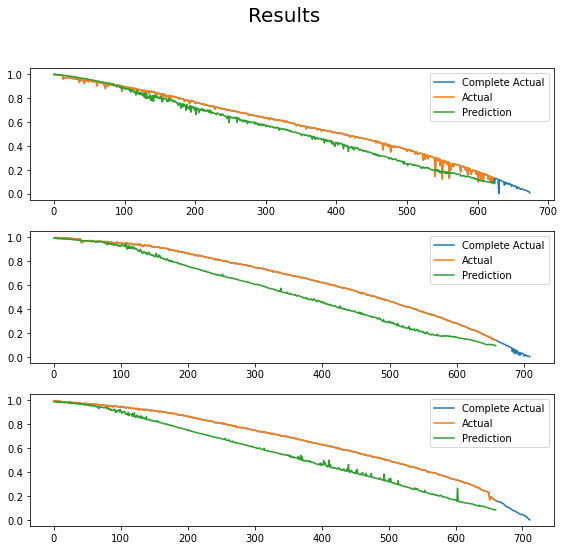

In [31]:
batteries =[0,1,2]
plot_RUL(model_RUL_scenario2,discharge_capacities,batteries,train_dataloader_RUL_temp,change_indices_train,True)



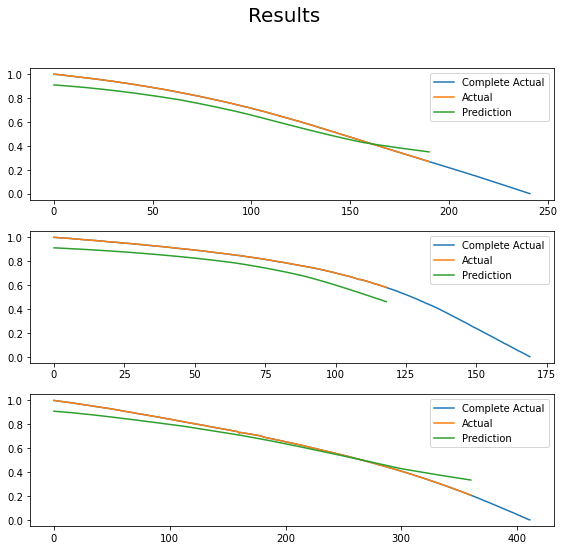

In [25]:
test_batteries  = [i+100 for i in [16,17,18]]
plot_RUL(model_RUL,discharge_capacities,test_batteries,test_dataloader_RUL,change_indices_test,True)

In [29]:
from torchmetrics import MeanAbsolutePercentageError

def plot_RUL_scenario1(model,discharge_capacities,batteries,data_loader,change_indices):

    rows = 1
    col  = len(batteries)
    fig, ax = plt.subplots(col,rows,figsize=(12,40))
    ax = ax.flatten()
    plt.suptitle("Results", fontsize = 20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    mse_loss = 0
    mae_loss =0 
    mape_loss =0 
    for ind,battery in enumerate(batteries):
        pred = []
        count = 0
        actual = []
        for x, y ,_ in data_loader:
            x = x.to(device)
            y = y.to(device)

            initial_count = count

            if(_[0][7:] == str(battery)):
                out = model(x)
                pred.append(out.cpu().detach().numpy()[0][0].astype(float))
                actual.append(y.cpu().detach().numpy()[0].astype(float))
                count = count +1
            if(initial_count==count and count >1):
                break
        
        if(battery>=100):
            change_indices_battery = battery - 100
        else:
            change_indices_battery = battery

        l = nn.MSELoss()
        l1 = nn.L1Loss()
        l2 = MeanAbsolutePercentageError()
        mse_loss += l(torch.Tensor(pred),torch.Tensor(actual))
        mae_loss += l1(torch.Tensor(pred),torch.Tensor(actual))
        mape_loss += l2(torch.Tensor(pred),torch.Tensor(actual))
        
        
        # plt.plot(list(discharge_capacities[battery][0][:change_indices[change_indices_battery]]) + list(pred))
        # plt.plot(list(discharge_capacities[battery][0][:change_indices[change_indices_battery]]) + list(actual))
        
        # plt.plot(discharge_capacities[battery][0])
        
        # plt.plot(discharge_capacities[battery][0])
        # print(pred)
        # plt.plot(pred)
        # plt.plot(actual)
        # plt.plot(discharge_capacities[battery][0][change_indices[change_indices_battery]:])
        
        x = [change_indices[change_indices_battery]+i for i in range(len(pred))]
        # print(len(discharge_capacities[battery][0]))
        ax[ind].plot(x,pred)
        ax[ind].plot(x,actual)
        ax[ind].legend(['Predicted', 'Actual'])
        ax[ind].set_title("Battery"+str(battery))
    print("MSE", mse_loss/len(batteries))
    print("MAE", mae_loss/len(batteries))
    print("MAPE", mape_loss/len(batteries))
    plt.savefig('RUL_prediction.png')


MSE tensor(0.0035)
MAE tensor(0.0454)
MAPE tensor(0.0882)


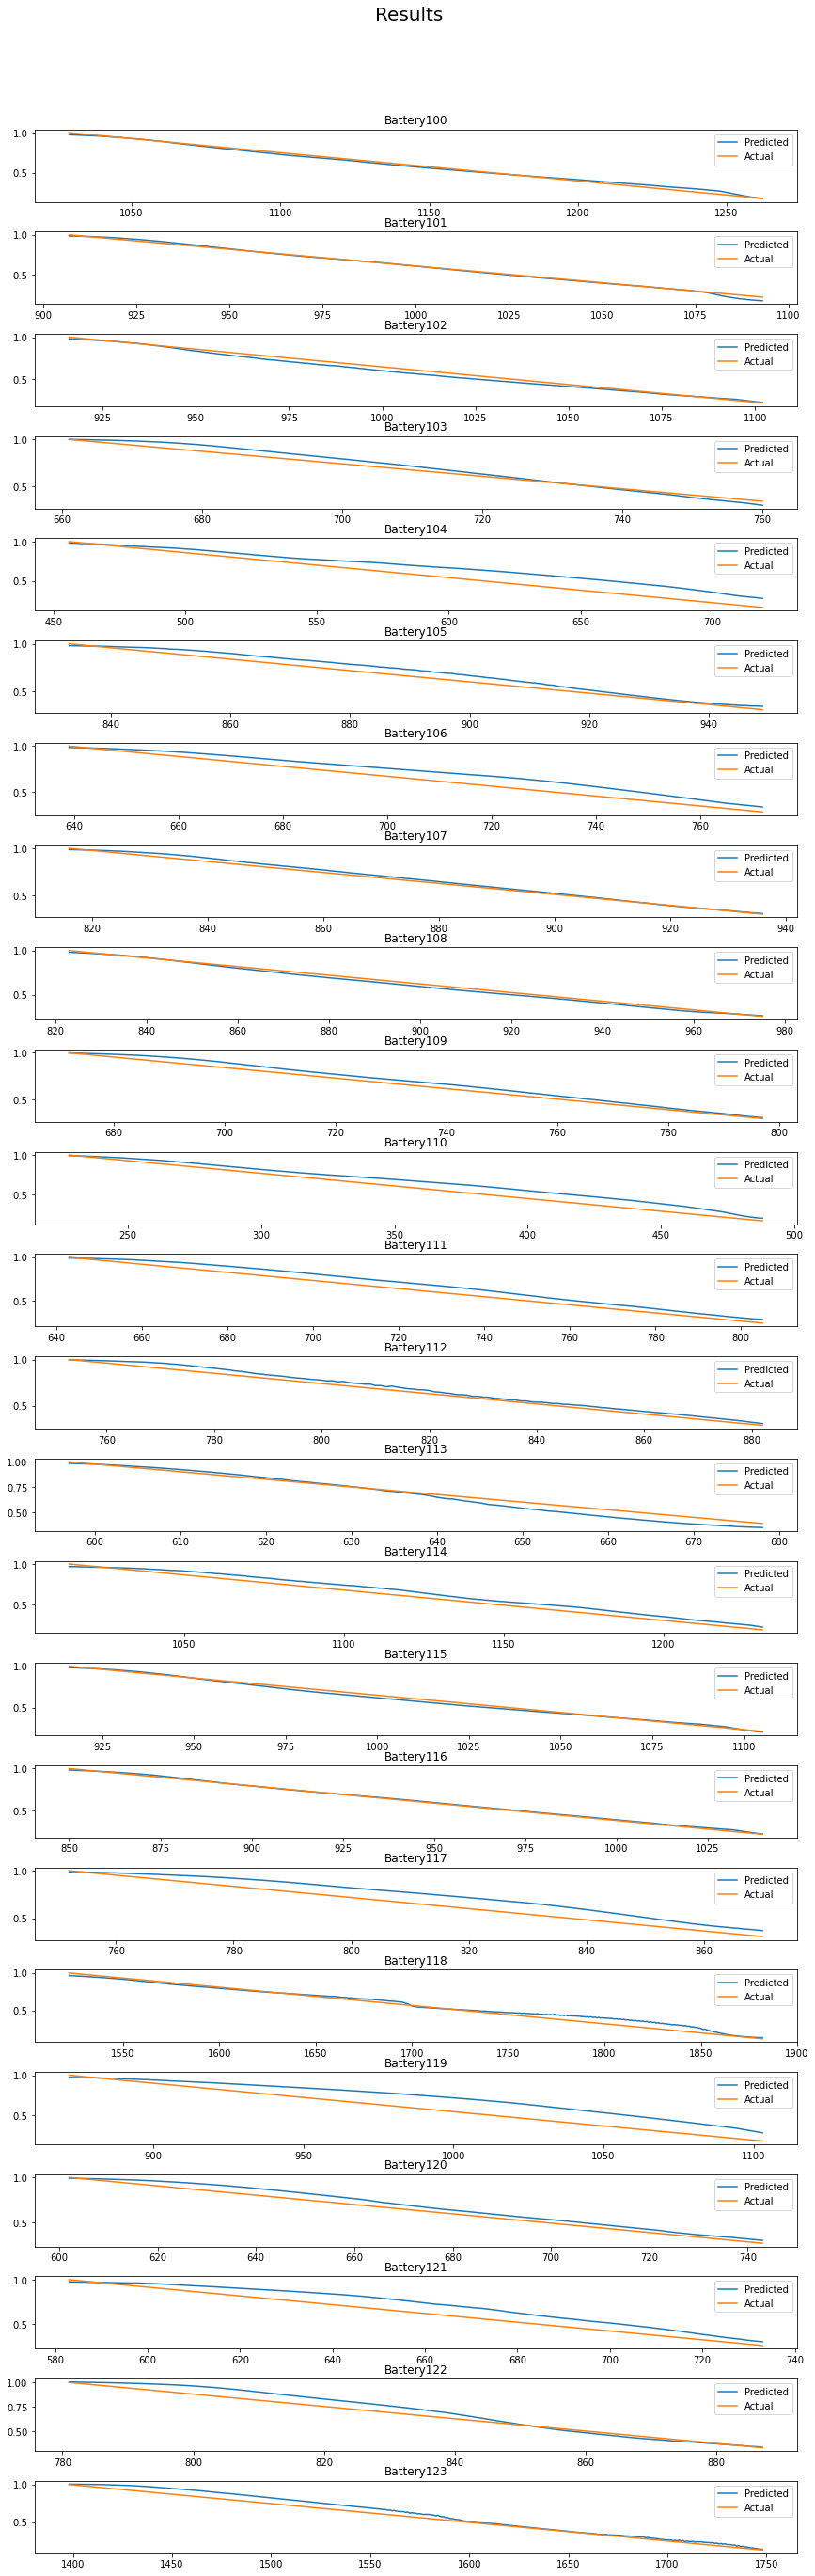

In [27]:
test_batteries  = [i+100 for i in range(24)]
plot_RUL_scenario1(model_RUL_scenario1,discharge_capacities,test_batteries,test_dataloader_RUL_scenario1,change_indices_test)

MSE tensor(0.0007)
MAE tensor(0.0215)
MAPE tensor(0.0464)


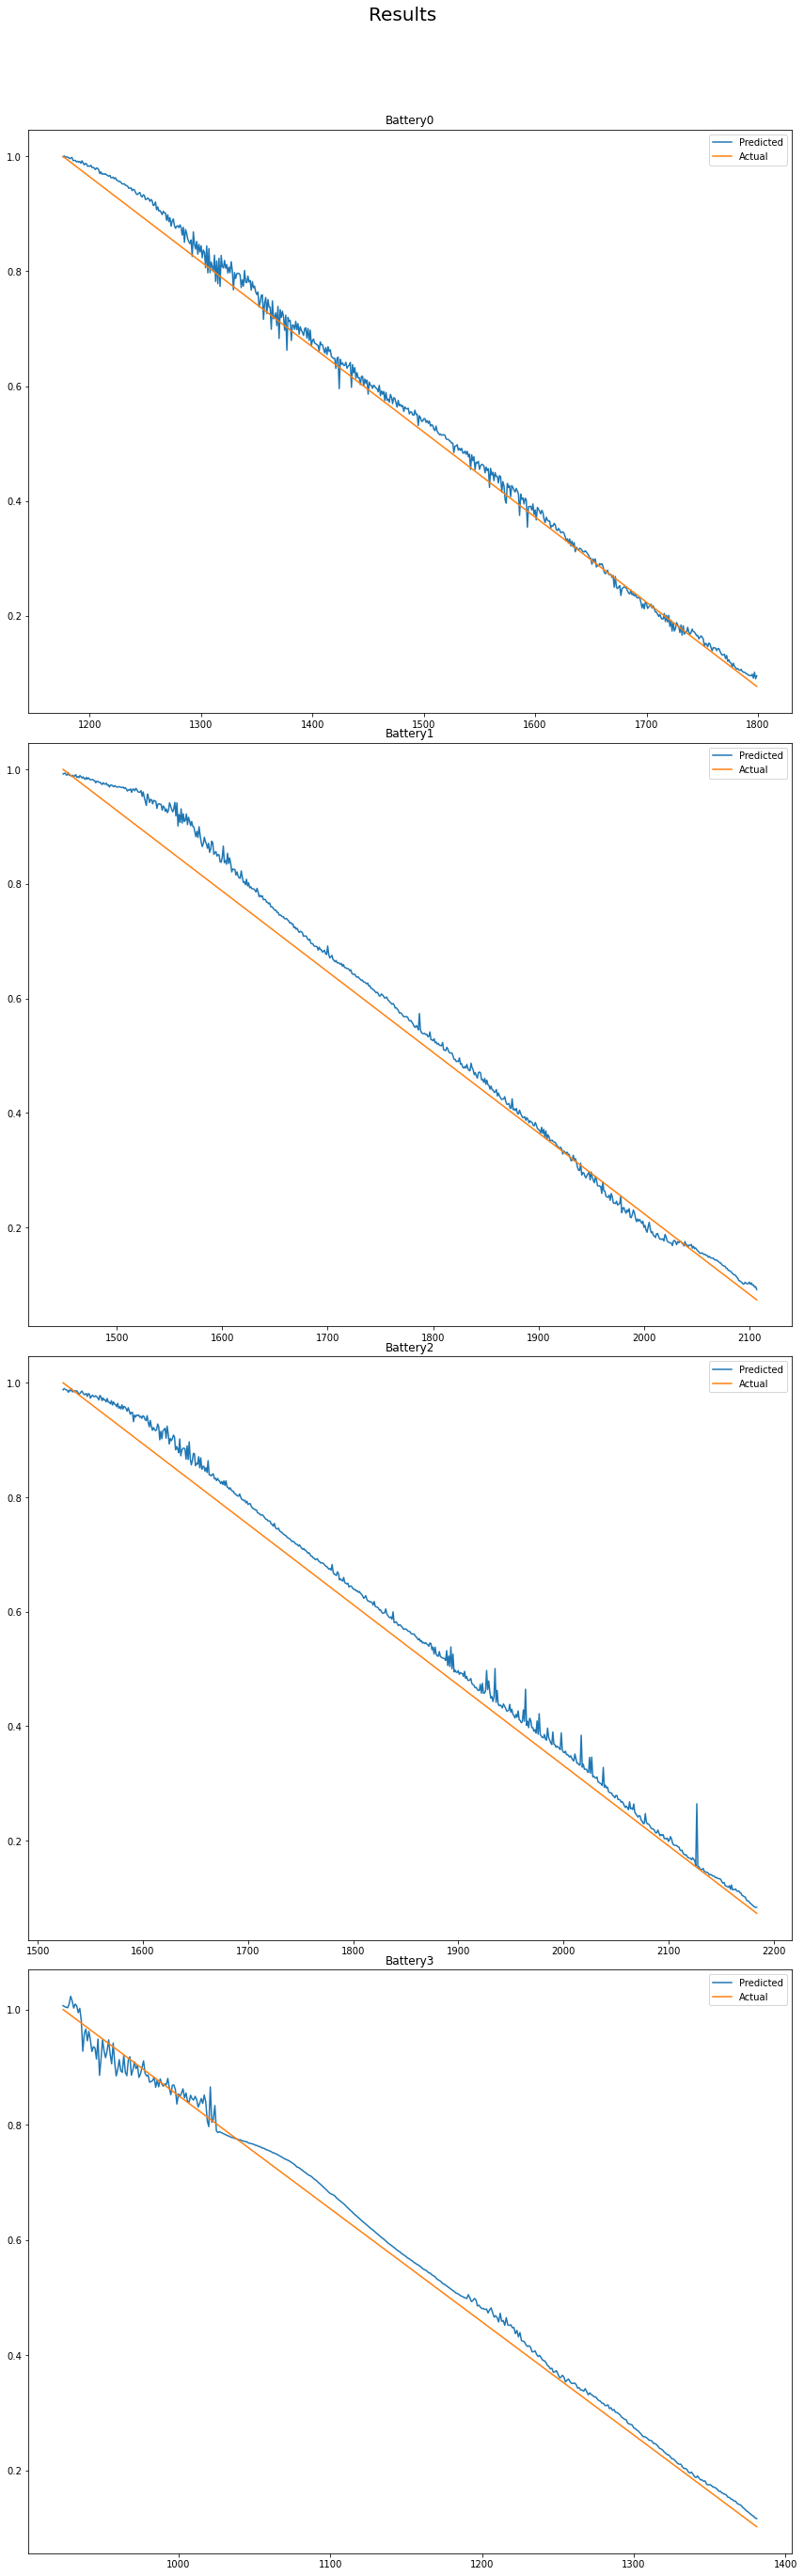

In [30]:
batteries =[0,1,2,3]
plot_RUL_scenario1(model_RUL_scenario1,discharge_capacities,batteries,train_dataloader_RUL_temp_scenario1,change_indices_train)